Домашнее задание 10 (после Лекции №11)
Задание №1: 

1. Для любых пар изображений которые имеют общее поле зрения (две фотографии сделанные с телефона который был повернут на определенный угол - любой лишь бы было 20+% перекрытия)
Рассчитать матрицу афинного преобразования из одной системы координат в другую. Выполнить разложение данной матрицы и посчитать явно угол поворота, вектор переноса и скалирования. 
Выполнить обратное преобразование - получить афинную матрицу заново. 

Анализ задания: используем функции библиотеки OpenCV, в частности, детектор SIFT. Определяем набор характерных точек в каждом изображении, сопоставляем наборы точек. С помощью набора соответственных пар точек рассчитываем аффинное преобразование, переводящее один набор точек в другой.
Далее, зная структуру матрицы аффинного  преобразования, вытягиваем из нее компоненты, отвечающие за трансляцию, поворот, масштабирование и деформацию сдвига.
После этого заново собираем матрицу, уже из отдельных компонент, отвечающих за каждое аффинное преобразование.


Загрузка файлов картинок в соответствующие переменные

In [1]:
quit # reset all variables for repeated run of the program

# loading necessary libraries and two pictures
import cv2
import numpy as np
import matplotlib.pyplot as plt

path1 = 'pic1.jpg'  # 1st picture, file name (and path if necessary)
path2 = 'pic2.jpg'  # second picture
try:
    pic1 = cv2.imread(path1)
    pic2 = cv2.imread(path2)
    print('Pictures have been read')
except:
    print('File reading error')


Pictures have been read


Вывод загруженных картинок на экран

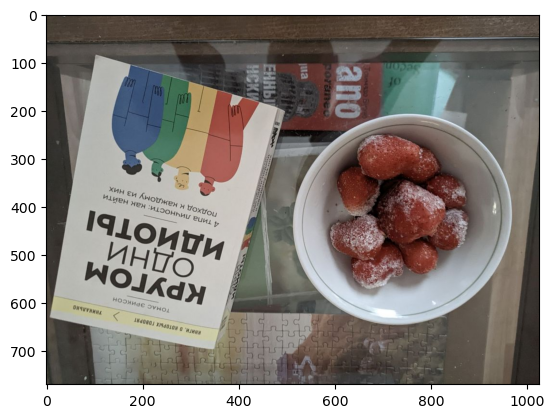

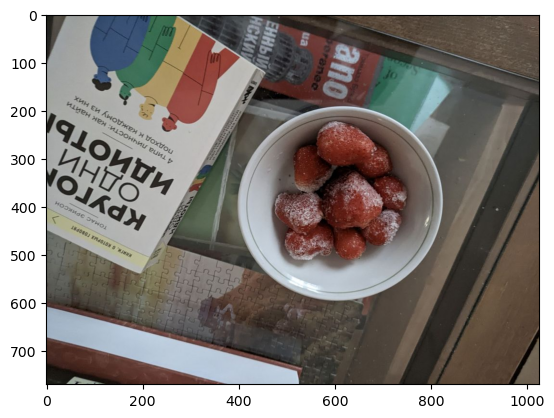

In [2]:
# cv2.imshow('1st picture', pic1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# cv2.imshow('2nd picture', pic2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# plt.figure(figsize=(16, 6), dpi=100)

# convert color image into RGB image 
img1 = cv2.cvtColor(pic1, cv2.COLOR_BGR2RGB) 
# show image 1
plt.imshow(img1)
plt.show()
img2 = cv2.cvtColor(pic2, cv2.COLOR_BGR2RGB) 
# show image 2
plt.imshow(img2)
plt.show()

Функция извлечения характерных точек из рисунка (здесь и далее - взято из файла блокнота Юпитер к лекции)

In [3]:
def extract_features(image, detector = 'sift', mask = None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image
    detector: 'sift' or 'orb' or 'surf'. The default is 'sift'
    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

Функция сопоставления пар точек, детектор SIFT или ORB. Мы используем sift.

In [4]:
def match_features(des1, des2, matching='BF', detector='sift', sort = True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k = k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k = k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

Функция фильтрации пар точек по расстоянию

In [5]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

Функция визуализации найденных пар точек

In [6]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)
    # Убираем оси
    plt.axis('off')

    # Сохраняем график в файл
    plt.savefig('plot_matches_sift.png', bbox_inches='tight', pad_inches=0)

Находим характерные точки на двух загруженных рисунках.
Находим пары соответственных точек.
Фильтруем их по расстоянию
Демонстрируем найденные пары на загруженных рисунках

Number of matches before filtering: 3102
Number of matches after filtering: 185


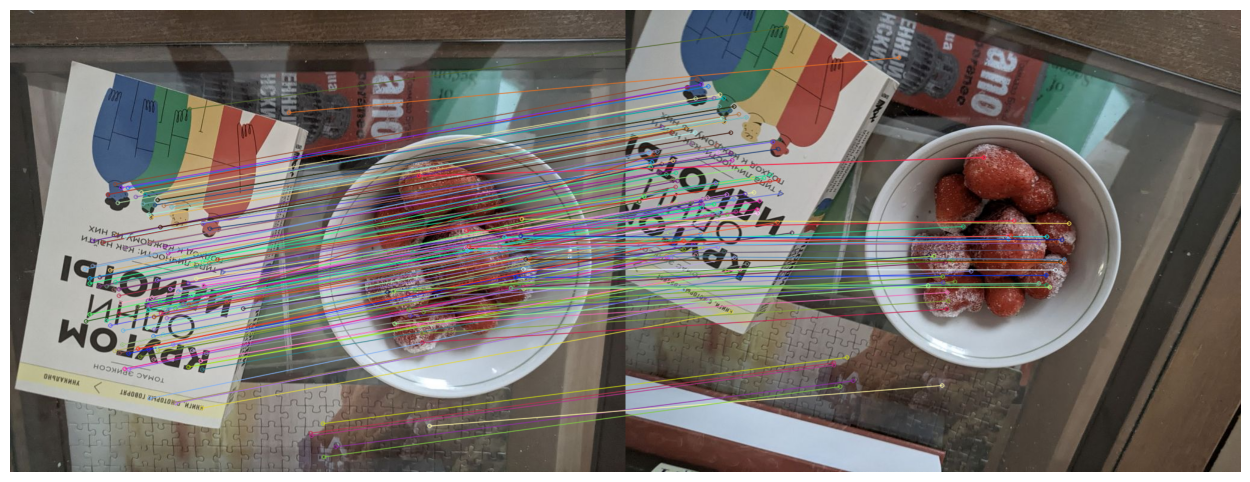

In [7]:
kp1, des1 = extract_features(img1, 'sift')
kp2, des2 = extract_features(img2, 'sift')
matches = match_features(des1, des2, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.345) # min distance is 0.345
print('Number of matches after filtering:', len(matches))
visualize_matches(img1, kp1, img2, kp2, matches)

Функция отыскания смещения и угла поворота

In [8]:

def estimate_partial_transform(cur_matched_kp, prev_matched_kp, method):
    """    
    :param matched_keypoints: output of match_keypoints util function; tuple of (cur_matched_kp, prev_matched_kp)
    :return: transform as list of [dx, dy, da]
    """
    transform = cv2.estimateAffine2D(np.array(prev_matched_kp), np.array(cur_matched_kp),method=method)[0] 
                                                                                      
    #print(transform)    
    if transform is not None:
        # translation x
        dx = transform[0, 2]
        # translation y
        dy = transform[1, 2]
        # rotation
        da = np.arctan2(transform[1, 0], transform[0, 0])
    else:
        dx = dy = da = 0

    return [dx, dy, da], transform

Преобразование для подстановки в качестве аргументов для функции элементарных аффинных преобразования

In [9]:
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
m , M = estimate_partial_transform(src_pts,dst_pts, cv2.LMEDS)

Рассчитываем матрицу аффинного преобразования

In [10]:
affine_transform_matrix =  np.append(M,np.array([0,0,1])).reshape(3,3)
affine_transform_matrix

array([[  0.98016912,   0.22554896,  32.48059829],
       [ -0.28680092,   0.99788266, 206.51665369],
       [  0.        ,   0.        ,   1.        ]])

Функция для разложения матрицы аффинного преобразования на элементарные движения - компоненты (смещение, масштабирование, поворот в градусах, и сдвиг)

In [11]:
def decompose_affine_matrix(matrix):
    """
    Decomposes affinic matrix into components: shift (смещение), scaling (масштабирование), rotation (поворот) and shear (сдвиг).
    Args:
        matrix (numpy.ndarray): Аффинная матрица размером 3x3.
    Returns:
        dict: Словарь с компонентами: 'translation', 'scale', 'rotation_angle', 'shear'.
    """

    # Проверяем, что матрица имеет правильный размер
    if matrix.shape != (3, 3):
        raise ValueError("Матрица должна быть размером 3x3")

    # Извлекаем компоненты
    a, b, tx = matrix[0, 0], matrix[0, 1], matrix[0, 2]
    c, d, ty = matrix[1, 0], matrix[1, 1], matrix[1, 2]

    # Вычисляем смещение
    translation = (tx, ty)

    # Вычисляем масштабирование
    sx = np.sqrt(a**2 + c**2)
    sy = np.sqrt(b**2 + d**2)

    # Нормализуем для извлечения угла поворота
    if sx == 0 or sy == 0:
        raise ValueError("Масштабирование равно нулю")

    rotation_matrix = np.array([[a, b], [c, d]]) / np.array([[sx, sx], [sy, sy]])
    theta = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0]) # in radians   
    rotation_angle = np.rad2deg(theta) # to degrees

    # Вычисляем сдвиг
    shear = (a * b + c * d) / (sx * sy)

    return {
        "translation": translation,
        "scale": (sx, sy),
        "rotation_angle": rotation_angle,
        "shear": shear
    }

Применяем функцию разложения матрицы на элементарные аффинные преобразования

In [12]:
result = decompose_affine_matrix(np.linalg.inv(affine_transform_matrix))
print("Translation:", result["translation"])
print("Scaling:", result["scale"])
print("Rotation angle (rad):", np.deg2rad(result["rotation_angle"]))
print("Rotation angle (degrees):", result["rotation_angle"])
print("Shear:", result["shear"])

Translation: (13.586539050892682, -203.049946760778)
Scaling: (0.9956828993143723, 0.9645215799698619)
Rotation angle (rad): 0.28842189067182494
Rotation angle (degrees): 16.525357054679215
Shear: 0.0536653677589611


Обратный переход от элементарных аффинных преобразований к матрице аффинного преобразования 

In [13]:
def compose_affine_matrix(components):
    """
    Создает аффинную матрицу из компонентов: смещение, масштабирование, поворот и сдвиг
    Args:
        components (dict): Словарь с компонентами: 'translation', 'scale', 'rotation_angle', 'shear'.
    Returns:
        numpy.ndarray: Аффинная матрица размером 3x3.
    """

    translation = components["translation"]
    scale = components["scale"]
    rotation_angle = components["rotation_angle"]
    shear = components["shear"]

    R = np.array([
        [np.cos(np.radians(rotation_angle)), np.sin(np.radians(rotation_angle)), 0],
        [-np.sin(np.radians(rotation_angle)), np.cos(np.radians(rotation_angle)), 0],
        [0, 0, 1]
    ])

    T = np.array([
        [1, 0, translation[0]],
        [0, 1, translation[1]],
        [0, 0, 1]
    ])

    S = np.array([
        [scale[0], 0, 0],
        [0, scale[1], 0],
        [0, 0, 1]
    ])

    Sh = np.array([
        [1, shear * scale[0] / scale[1], 0],
        [0, 1, 0],
        [0, 0, 1]
    ])

    A = T @ R @ Sh @ S #@ np.linalg.inv(T)
    A = T @ R @ S #@ np.linalg.inv(T)

    return A

Собираем обратно матрицу аффинного преобразования

In [14]:
components = result
restored_matrix = compose_affine_matrix(components)

Сравниваем исходную рассчитанную матрицу элементарного преобразования и восстановленную из элементарных преобразований, вычитая одну из другой. Должны получить нулевую матрицу:

In [15]:
print(affine_transform_matrix)
print(restored_matrix)
print(restored_matrix - affine_transform_matrix)

[[  0.98016912   0.22554896  32.48059829]
 [ -0.28680092   0.99788266 206.51665369]
 [  0.           0.           1.        ]]
[[   0.95455517    0.27434819   13.58653905]
 [  -0.2832117     0.924681   -203.04994676]
 [   0.            0.            1.        ]]
[[-2.56139474e-02  4.87992268e-02 -1.88940592e+01]
 [ 3.58921742e-03 -7.32016645e-02 -4.09566600e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


Видим, что получилось расхождение.
Также найдем матрицу обратного аффинного  преобразования (от второго кадра к первому)
Не путаем с восстановлением исходной матрицы обратно из элементарных аффинных преобразований, это совсем другое.

In [16]:
inv_matrix = np.linalg.inv(affine_transform_matrix) 
print(inv_matrix)

[[   0.95694328   -0.21629553   13.58653905]
 [   0.27503455    0.93995645 -203.04994676]
 [   0.            0.            1.        ]]


In [17]:
print(inv_matrix @ affine_transform_matrix) # checking: unity matrix should be obtained

[[ 1.00000000e+00 -2.77555756e-17 -7.10542736e-15]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Выводы:
В ходе работы проведено нахождение соответствующих пар точек на двух фото, сделанных со смещением и поворотом.
Найдена матрица аффинного преобразования, с помощью метода sift библиотеки cv2.
Из данной матрицы извлечены отдельно вектор смещения, коэффициент масштабирования, угол поворота и сдвиг.
С использованием найденных отдельных аффинных преобразований обратно составлена матрица аффинного преобразования.
Также получена обратная матрица аффинного преобразования от второго кадра к первому.
